# U-Net Full implementation

## Load necessary packages

In [1]:
import random
import os
import sys
import warnings
import datetime

from tqdm import tqdm

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import numpy.matlib
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt

import scipy
from scipy.signal import butter, filtfilt
from scipy.stats import norm
import scipy.io

import segyio

from skimage.metrics import structural_similarity as ssim
# from skimage.measure import compare_ssim 
from skimage.metrics import peak_signal_noise_ratio as psnr

#TensorFlow libraries
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda, Layer, ReLU, Add
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import concatenate, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

## Define parameters

In [2]:
## Parameters used in gathers:
Ntrainingsamples = 80      # Number of gathers windowed to generate training examples[-]
Ntestsamples = 1           # Number of test examples for the network to interpolate
dt = 0.004                 # Sampling rate [s]
Fs = 1/dt                  # Sampling frequency (500 Hz)
noiselevel = 0.1           # Percent noise
RandomFilts = 1            # Turn on for using 2 random 10 Hz frequency ranges
TracesPerGather = 635      # Number of traces in each gather. Default for NoSI_short is 636.

#Lower boundary of filter
flp = 20 


#Windowing Parameters:
input_width = 64         # Columns in window (space)
input_height = 512       # Rows in window (time)
overlap = 0.5            # Ratio of overlap

start_time = 0           # Where to start reading each gather incase you wish to cut off some samples
end_time = 1024          # Where to stop reading each gather. Use '-1' to select the last sample


#Network parameters
dropout = 0.0
BatchSize = 4
ValidationSplit = 0.2
Epochs = 20

## File location:
TRAINX_PATH = '/Users/samtu/Documents/'
filename = 'NoSI_short.segy'

### Test for GPU

This short line is to test whether your GPU is being used to run the network. If it is, then it should be listed as GPU.

In [ ]:
print(f'TensorFlow Version:',tf.__version__)
print(tf.config.list_physical_devices())

## Define functions

The following cell defines necessary functions to geneate the training and test data, as well as necessary functions to create the neural network.  
There are 3 sections:
1. Filters
2. Loss functions
3. Neural network building blocks

In [3]:
#Filters to remove the 'missing' from the broadband data:

#Band-stop filter to remove the missing band
def myFilterStop(data,flp,fhi,delt):
    #c - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampling interval of the data
    
    y = data.shape[0]
    data2 = np.vstack((np.flipud(data),data,np.flipud(data)))
    slope = np.hanning(2*y).reshape((2*y,1))
    slope1 = slope[0:y]
    slope2 = np.ones((y,1))
    slope3 = slope[y:2*y]
    slope = np.vstack((slope1, slope2, slope3))

    #multiply with a nice window function
    for i in range(3*y):
        data2[i] = data2[i] * slope[i]

    n = 5 #order Butterworth filter
    fnq = 1.0 / (2*delt) #Nyquist
    Wn = [flp/fnq, fhi/fnq] #Butterworth non-dim freq
    b,a = butter(n,Wn,'bandstop',output='ba') #construct the filter
    d = filtfilt(b,a,data2,axis=0) #zero phase filter

    #pick out the part that I actually want
    d = d[1*y + 0:2*y , :]
    return d

#Band-pass filter to remove all but the missing frequency band. This was used to test the networks perforance on reconstructing
#missing frequencty data.
def myFilterPass(data,flp,fhi,delt):
    #c - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampling interval of the data
    
    y = data.shape[0]
    data2 = np.vstack((np.flipud(data),data,np.flipud(data)))
    slope = np.hanning(2*y).reshape((2*y,1))
    slope1 = slope[0:y]
    slope2 = np.ones((y,1))
    slope3 = slope[y:2*y]
    slope = np.vstack((slope1, slope2, slope3))

    #multiply with a nice window function
    for i in range(3*y):
        data2[i] = data2[i] * slope[i]

    n = 5 #order Butterworth filter
    fnq = 1.0 / (2*delt) #Nyquist
    Wn = [flp/fnq, fhi/fnq] #Butterworth non-dim freq
    b,a = butter(n,Wn,'bandpass',output='ba') #construct the filter
    d = filtfilt(b,a,data2,axis=0) #zero phase filter

    #pick out the part that I actually want
    d = d[1*y + 0:2*y , :]
    return d

#Zeroing strong filter
def myStrongFilter(data,flp,fhi,delt):
    #data - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampling interval of the data
    
    flp = flp/2
    fhi = fhi/2
    
    Fs = 1/delt
    Nyq = Nyq = Fs/2
    
    Data_Freq = fft(data,axis=0)
    Filter = np.ones(Data_Freq.shape)
    Filter[int(np.ceil((flp/Nyq)*Data_Freq.shape[0])):int(np.ceil((fhi/Nyq)*Data_Freq.shape[0])),:] = 0
    Filter[-int(np.ceil((fhi/Nyq)*Data_Freq.shape[0])):-int(np.ceil((flp/Nyq)*Data_Freq.shape[0])),:] = 0

    Data_Freq_Filt = Data_Freq*Filter
    
    return np.real(ifft(Data_Freq_Filt,axis=0))


#Two custom loss functions:

#This loss function looks into the spatially similarity of the gather.
def MyLoss(y_true, y_pred):
    
    #Compute Huber loss
    h = tf.keras.losses.Huber()
    L1 = h(y_true, y_pred)
    
    #Compute structural similarity index
    SSIM = tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
    
    return   1 - SSIM + L1


#Frequency loss function that takes the frequency data into account. 
def FreqLoss(y_true, y_pred):
    
    #Create Huber loss function
    h = tf.keras.losses.Huber()
    L1 = h(y_true, y_pred)
    
    #Cast in- and output data in complex for to perform fft
    y_true_f = tf.dtypes.cast(y_true, tf.complex64)
    y_pred_f = tf.dtypes.cast(y_pred, tf.complex64)
    
    #Compute fft
    y_true_fft = tf.signal.fft3d(y_true_f)
    y_pred_fft = tf.signal.fft3d(y_pred_f)
    
    #Compute MAE of frequency domain data
    FreqRMS = tf.math.reduce_mean(tf.abs(y_true_fft-y_pred_fft))
    
    return FreqRMS + L1


#Defining necessary layers for the neural network

#Coordinate Attention block. Taken from: https://github.com/Andrew-Qibin/CoordAttention
#This function is unused in the actual network unless uncommented
def CoordAtt(x, reduction=32, bn_trainable=False):
    def coord_act(x):
        tmpx = (ReLU(max_value=6)(x + 3)) / 6
        x = x * tmpx
        return x

    x_shape = x.shape.as_list()
    [b, h, w, c] = x_shape
    
    x_h = AveragePooling2D(pool_size=(1, w), strides=(1, 1), data_format='channels_last')(x)
    x_w = AveragePooling2D(pool_size=(h, 1), strides=(1, 1), data_format='channels_last')(x)
    x_w = K.permute_dimensions(x_w, [0, 2, 1, 3])
    
    y = concatenate(inputs=[x_h, x_w], axis=1)
    
    mip = max(8, c // reduction)
    
    y = Conv2D(filters=mip, kernel_size=(1, 1), strides=(1, 1), padding='valid')(y)
    y = BatchNormalization(trainable=bn_trainable)(y)
    y = coord_act(y)
    
    x_h, x_w = Lambda(tf.split, arguments={'axis': 1, 'num_or_size_splits': [h, w]})(y)
    
    x_w = K.permute_dimensions(x_w, [0, 2, 1, 3])
    
    a_h = Conv2D(filters=c, kernel_size=(1, 1), strides=(1, 1), padding='valid', activation="sigmoid")(x_h)
    a_w = Conv2D(filters=c, kernel_size=(1, 1), strides=(1, 1), padding='valid', activation="sigmoid")(x_w)
    
    out = x * a_h * a_w
    
    return out


#Convolution block
def conv_block(inp, num_filters):
    x = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(inp)
    x = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(x)
#     coordinate_attention = CoordAtt(x)
#     x = Add()([coordinate_attention, x])
    return x

#Encoding block
def encoder_block(inp, num_filters):
    x = conv_block(inp, num_filters) #also the skip feature
    p = MaxPooling2D((2, 2))(x) #output to the next block
    return x, p

#Decoding block
def decoder_block(inp, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (3, 3), strides=(2,2), padding="same",kernel_initializer='HeNormal')(inp)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x



## Generate Training data (by windowing)

This section of the code generates the training gathers for the neural network. The same steps are performed for the training data as for the test data, as follows:  
1. Open the `.sgy` or `.segy` file containing the gathers
2. Filter the out a certain frequency band with a bandpass filter, which will be the input gathers into the neural network.
3. Divide the gather into different (over-lapping) windows, so that there are less parameters being input into the neural network, and thus it is less demanding to run.
4. Save the windows containing the filtered gathers into X_train (input) and the unfiltered gathers into Y_train (objective).
5. The same steps are repeated for generating the test data.
6. Unnecessary windows are removed from the training data.
7. The data is normalized by the same coefficient to improve the network's performance. The new scale is from 0 to 1.
8. Finally, remaining unused variables are removed to save memory.

In [5]:
# Get and resize train images and masks
# Number of layers is num. gather * num. windows per gather

#Read the SEGY with segyio and split into gathers
counter = 0

#Define ouput windows
output_width = np.round(overlap*input_width) 
output_height = np.round(overlap*input_height)
        
#Open the segy data files.
with segyio.open(TRAINX_PATH + filename, ignore_geometry=True) as f:
    
     #============================= GENERATE TRAINING DATA =====================================
        
    print('Getting training images ... ')
    NumWindows = int(np.floor(TracesPerGather/output_width)*np.floor(len(f.samples)/output_height))
    
    #Define matrices to be filledin
    X_train = np.zeros((Ntrainingsamples * NumWindows*4, input_height, input_width, 1))
    Y_train = np.zeros((Ntrainingsamples * NumWindows*4, input_height, input_width, 1))
    
    X_test = np.zeros((Ntestsamples * NumWindows*4, input_height, input_width, 1))
    Y_test = np.zeros((Ntestsamples * NumWindows*4, input_height, input_width, 1))
    
    #Frequencies to be removed, note that this number should be changed in case the number/type of filters change
    freqRemoveTrain = np.zeros((Ntrainingsamples * NumWindows*4,4))
    freqRemoveTest = np.zeros((Ntestsamples * NumWindows*4,4))
    
    for k in tqdm(np.arange(Ntrainingsamples)):
        
        #Select the traces of each gather
        gather = f.trace.raw[:].T.reshape((len(f.samples),f.tracecount))[start_time:end_time,k+k*(TracesPerGather) : k+(k+1)*(TracesPerGather)]
        
        
#         #Adding a gain:
#         t = np.arange(0,endtime*dt,dt)**1.4
#         t2gain = np.repeat(t,numberoftraces).reshape(endtime,numberoftraces)
#         gather = gather*t2gain
        
        
        #Filter out frequencies
        freqRemoveTrain[k,0] = flp;
        freqRemoveTrain[k,1] = freqRemoveTrain[k,0] + 5;

        gatherfilt = myStrongFilter(gather,freqRemoveTrain[k,0],freqRemoveTrain[k,1],dt);
        
        #Add noise
        np.random.seed(k+1)
        sample = noiselevel*norm.ppf(np.random.rand(gatherfilt.shape[0], gatherfilt.shape[1]))
        gatherfilt = gatherfilt + sample
        
        #Apply windowing to gather (My appolgies for making it hard to read, but it's faster than having if/else)
        for j in np.arange(0, gather.shape[0], output_height):
            for i in np.arange(0, gather.shape[1], output_width):

                input_window = gather[int(np.min([np.max([0,j-output_height/2]) , gather.shape[0]-input_height])):
                                      int(np.min([np.max([0,j-output_height/2]) + input_height , gather.shape[0]])),
                                      int(np.min([np.max([0,i-output_width/2]) , gather.shape[1]-input_width])):
                                      int(np.min([np.max([0,i-output_width/2]) + input_width , gather.shape[1]]))]
                
                input_windowfilt = gatherfilt[int(np.min([np.max([0,j-output_height/2]) , gatherfilt.shape[0]-input_height])):
                                              int(np.min([np.max([0,j-output_height/2]) + input_height , gatherfilt.shape[0]])),
                                              int(np.min([np.max([0,i-output_width/2]) , gatherfilt.shape[1]-input_width])):
                                              int(np.min([np.max([0,i-output_width/2]) + input_width , gatherfilt.shape[1]]))]


                
                #Fill window into training matrix
                X_train[counter] = input_windowfilt.reshape(input_height,input_width,1)
                Y_train[counter] = input_window.reshape(input_height,input_width,1)
    
    
                #Add to counter
                counter += 1
            
    #============================= GENERATE TEST DATA =====================================
    
    print('Getting test images ... ')
    counter = 0
    
    #The remaining samples (or number of gathers selected) of the dataset will be used as test data. 
    for k in tqdm(np.arange(Ntrainingsamples, Ntrainingsamples + Ntestsamples)):

#     k=199 #Use this instead of the above for-loop to only create one gather and compare to the sparse solver 

        #Select the traces of each gather
        gather = f.trace.raw[:].T.reshape((len(f.samples),f.tracecount))[start_time:end_time,k+k*(TracesPerGather) : k+(k+1)*(TracesPerGather)]

        #Filter out frequencies
        freqRemoveTest[k,0] = flp;
        freqRemoveTest[k,1] = freqRemoveTest[k,0] + 5;

        gatherfilt = myStrongFilter(gather,freqRemoveTest[k,0],freqRemoveTest[k,1],dt);

        #Add noise
        np.random.seed(k+1)
        sample = noiselevel*norm.ppf(np.random.rand(gatherfilt.shape[0], gatherfilt.shape[1]))
        gatherfilt = gatherfilt + sample

        #Apply windowing to gather
        for j in np.arange(0, gather.shape[0], output_height):
            for i in np.arange(0, gather.shape[1], output_width):

                input_window = gather[int(np.min([np.max([0,j-output_height/2]) , gather.shape[0]-input_height])):
                                      int(np.min([np.max([0,j-output_height/2]) + input_height , gather.shape[0]])),
                                      int(np.min([np.max([0,i-output_width/2]) , gather.shape[1]-input_width])):
                                      int(np.min([np.max([0,i-output_width/2]) + input_width , gather.shape[1]]))]

                input_windowfilt = gatherfilt[int(np.min([np.max([0,j-output_height/2]) , gather.shape[0]-input_height])):
                                              int(np.min([np.max([0,j-output_height/2]) + input_height , gather.shape[0]])),
                                              int(np.min([np.max([0,i-output_width/2]) , gather.shape[1]-input_width])):
                                              int(np.min([np.max([0,i-output_width/2]) + input_width , gather.shape[1]]))]

    #                 #Add noise
    #                 input_windowfilt = input_windowfilt + noiselevel * np.random.normal(input_height,input_width)


                #Fill window into training matrix
                X_test[counter] = input_windowfilt.reshape(input_height,input_width,1)
                Y_test[counter] = input_window.reshape(input_height,input_width,1)


                #Add to counter
                counter += 1    
        f.close()

print('Deleting empty arrays ...')
#The following lines look for any arrays that are all zeros and deletes them.
freqRemoveTrain = freqRemoveTrain[~np.all(X_train == 0, axis=(1,2,3))]
freqRemoveTest = freqRemoveTest[~np.all(X_test == 0, axis=(1,2,3))]
X_train = X_train[~np.all(X_train == 0, axis=(1,2,3))]
X_test = X_test[~np.all(Y_test == 0, axis=(1,2,3))]
Y_train = Y_train[~np.all(Y_train == 0, axis=(1,2,3))]
Y_test = Y_test[~np.all(Y_test == 0, axis=(1,2,3))]


print('Deleting duplicate arrays from training data ...')
#REMOVE DUPLICATES
_, b = np.unique(Y_train, return_index = 1 ,axis=0)
X_train = X_train[np.sort(b)] 
Y_train = Y_train[np.sort(b)]

# print('Deleting arrays with insignificant SNR ...')
# #The following windows contain only noisy event prior to the first arrivals.
# #I need to come up with a better way of removing these (more robust)
# indexes = np.concatenate([np.arange(0,9,1),np.arange(20,32,1),np.arange(40,57,1),np.arange(60,80,1)])
# indexes = np.repeat(indexes, Ntrainingsamples, axis=0).reshape((int(indexes.shape[0]),Ntrainingsamples))
# scalers = np.arange(0,(Ntrainingsamples)*80,80)
# scalers = np.matlib.repmat(scalers,int(indexes.shape[0]),1)
# ind2keep = indexes+scalers
# X_train = X_train[ind2keep.T.flatten()]
# Y_train = Y_train[ind2keep.T.flatten()]

# del indexes
# del scalers
# del ind2keep

print('Normalizing ...')
#Normalization:
normfac = np.max(np.array([
                              np.max(np.abs(X_train)), 
                              np.max(np.abs(Y_train)),
                              np.max(np.abs(X_test)), 
                              np.max(np.abs(Y_test))]))
X_train = ((X_train / normfac) + 1) / 2
Y_train = ((Y_train / normfac) + 1) / 2
X_test = ((X_test / normfac) + 1) / 2
Y_test = ((Y_test / normfac) + 1) / 2

#Deleting unnecessary variables to save memory
del gather
del _
del b

print('Done!')
print(f'There are {X_train.shape[0]} training samples.')
print(f'There are {X_test.shape[0]} test samples.')

Getting training images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [02:35<00:00,  1.95s/it]


Getting test images ... 
Deleting empty arrays ...
Deleting duplicate arrays from training data ...
Deleting arrays with insignificant SNR ...
Normalizing ...
Done!
There are 4640 training samples.
There are 80 test samples.


## Build Neural Net

In [ ]:
def build_unet(input_shape, start_neurons):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, start_neurons * 1) 
    s2, p2 = encoder_block(p1, start_neurons * 2)

    b1 = conv_block(p2, start_neurons * 16)

    d2 = decoder_block(b1, s2, start_neurons * 2)
    d1 = decoder_block(d2, s1, start_neurons * 1)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d1)

    model = Model(inputs, outputs, name="U-Net")
    return model

input_shape = (input_height, input_width, 1)
model = build_unet(input_shape, 32)
model.compile(loss= FreqLoss , optimizer="adam", metrics=["mean_squared_error"],)
model.summary()

## Fitting the Model

This cell will start training the U-Net. The `earlystopper` callback will stop training if no improvement in the loss function has been made for a specified number of epochs. The `checkpointer` callback will save the network's best performing parameters so that the network later be used for comparison.

You can change the name of the file to something meaningful.

In [ ]:
earlystopper = EarlyStopping(patience=15, 
                             verbose=1)
checkpointer = ModelCheckpoint(str(flp)+str(flp+5)+'_NoSI_short.h5', 
                               verbose=1, 
                               save_best_only=True)

history = model.fit(X_train, 
                    Y_train, 
                    validation_split=ValidationSplit, 
                    batch_size=BatchSize, 
                    epochs=Epochs, 
                    shuffle=1,
                    callbacks=[earlystopper, checkpointer]
                   )

## Plotting the progression

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '--b', label='Training error')
plt.plot(epochs, val_acc, 'r', label='Validation error')
plt.title('Training and validation error')
plt.legend()
plt.show()

ax = plt.figure()
plt.rc('font', size=12)
plt.plot(epochs, loss, '--b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.locator_params(axis='x', nbins=20)
plt.xlabel('# Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [ ]:
file_path = 'loss_'+str(flp)+str(flp+5)+'.mat'
# file_path = 'loss_'+str(flp)+str(flp+5)+'_2.mat'
scipy.io.savemat(file_path, {'loss': loss,'val_loss':val_loss})

# Make Predictions

The next step is to make predictions of datasets that have not been seen before.

If you want to make predictions with an already existing model that was previously saved, then uncomment the first section of the following cell.

<b>Sometimes, when using custom loss functions the model will be unable to compile. This can be circumvented by telling tensorflow to not compile the model, followed by then defining the loss function to be a known loss function such as MSE. Doing this shouldn't change the results.</b>

Once the model is loaded, predictions can be made.

In [7]:
#Load and compile the model as normal:
# model = load_model('model_unet_checkpoint.h5')

#If using custom loss functions:
# model = load_model('model_unet_checkpoint.h5', compile=False)
# model.compile(loss="mean_squared_error", optimizer='adam', metrics=["mean_squared_error"])


preds_test = model.predict(X_test, verbose=1)


3/3 [==============================] - 12s 2s/step


### Prediction test data (unseen)

Various plots are generated to compare the results. Some are more meaningful than others.

In [ ]:
# Perform a sanity check on some random validation samples

ix = random.randint(0, len(preds_test)-1)
# ix = 323
print(ix)

# for ix in range(len(preds_test)):
#     print(ix)
#     print(abs(np.array([Y_test[ix,:,:] - preds_test[ix,:,:]])).max())

f = plt.figure(figsize=(10,15))
ax1 = f.add_subplot(141)
plt.imshow(X_test[ix,:,:], cmap='gray')
plt.colorbar()
plt.title('Filtered + Noise')
plt.clim(0,1)

ax2 = f.add_subplot(142)
plt.imshow(Y_test[ix,:,:], cmap='gray')
plt.title('True data (Objective)')
plt.colorbar()
plt.clim(0,1)

ax3 = f.add_subplot(143)
plt.imshow(preds_test[ix,:,:], cmap='gray')
plt.title('Fitted data from Neural Network')
plt.colorbar()
plt.clim(0,1)

ax4 = f.add_subplot(144)
plt.imshow(abs(Y_test[ix,:,:] - preds_test[ix,:,:]),cmap = 'Reds')
plt.title('Absolute error')
plt.colorbar()
# plt.clim(0,0.05)
plt.show()

f = plt.figure(figsize=(10,15))
ax = f.add_subplot(131)
plt.imshow(abs(Y_test[ix,:,:] - preds_test[ix,:,:]),cmap = 'Reds')
plt.clim(0, 0.05)
plt.title('Absolute error of approximation')

ax = f.add_subplot(132)
plt.imshow(abs(Y_test[ix,:,:] - X_test[ix,:,:]),cmap = 'Reds')
plt.clim(0, 0.05)
plt.title('Error Objective and Test Data')


ax = f.add_subplot(133)
plt.imshow(abs(abs(Y_test[ix,:,:] - X_test[ix,:,:])-abs(Y_test[ix,:,:] - preds_test[ix,:,:])),cmap = 'Reds')
plt.title('Difference of both error plots')
plt.clim(0, 0.05)
plt.show()

print('The MAE of the input data was: ' + str(np.abs(np.mean(Y_test[ix,:,:]-X_test[ix,:,:]))))
print('The MAE of the ouput data was: ' + str(np.abs(np.mean(Y_test[ix,:,:]-preds_test[ix,:,:]))))
print('The max error of the input data was: ' + str(np.max(Y_test[ix,:,:]-X_test[ix,:,:])))
print('The max error of the ouput data was: ' + str(np.max(Y_test[ix,:,:]-preds_test[ix,:,:])))

# Finalizing the reconstruction

So in the cells above, predictions were made for individual windows. The next step is to combine each of these windows to create a full gather, which can then be used.

When combining the windows, two methods are possible. 
- The first is by simply combining the full windows side-by-side. This will, however, produce edge effects close to the window boundaries. The code for this is in the first next cell. 
- The second method is by combining the smaller output windows, which will then leave out any edge effects. This is shown in bellow in the second to next cell.

At the bottom of this cell we have the option to save the data to compare it to other interpolation methods.

First method:

In [ ]:
##Reconstruction of full gather:
#So this is the section where we reconstruct the original gather with the computed gathers.
trace = 100
nfft = 16*len(Y_test[0,:,0,:])

gather_obj = np.zeros((end_time,TracesPerGather+1,1))
gather_pred = np.zeros((end_time,TracesPerGather+1,1))
gather_test = np.zeros((end_time,TracesPerGather+1,1))

# Combining the windows here is the inverse process of generating the windows from above.

count = 0
for j in np.arange(0, gather_obj.shape[0], output_height):
    for i in np.arange(0, gather_obj.shape[1], output_width):
        
        gather_obj[int(np.min([ np.max([0,j-output_height/2]) , gather_obj.shape[0]-input_height])):
             int(np.min([np.max([0,j-output_height/2]) + input_height , gather_obj.shape[0]])),
             int(np.min([ np.max([0,i-output_width/2]) , gather_obj.shape[1]-input_width])):
             int(np.min([np.max([0,i-output_width/2]) + input_width , gather_obj.shape[1]])),:] = ((Y_test[count,:,:]*2)-1)*normfac
        
        gather_pred[int(np.min([ np.max([0,j-output_height/2]) , gather_obj.shape[0]-input_height])):
             int(np.min([np.max([0,j-output_height/2]) + input_height , gather_obj.shape[0]])),
             int(np.min([ np.max([0,i-output_width/2]) , gather_obj.shape[1]-input_width])):
             int(np.min([np.max([0,i-output_width/2]) + input_width , gather_obj.shape[1]])),:] = ((preds_test[count,:,:]*2)-1)*normfac
        
        gather_test[int(np.min([ np.max([0,j-output_height/2]) , gather_obj.shape[0]-input_height])):
             int(np.min([np.max([0,j-output_height/2]) + input_height , gather_obj.shape[0]])),
             int(np.min([ np.max([0,i-output_width/2]) , gather_obj.shape[1]-input_width])):
             int(np.min([np.max([0,i-output_width/2]) + input_width , gather_obj.shape[1]])),:] = ((X_test[count,:,:]*2)-1)*normfac
        
        count += 1

        
## Plotting   
f = plt.figure(figsize=(15,25))
ax = f.add_subplot(121)
plt.imshow(gather_obj[:,:,0]-gather_test[:,:,0],cmap='gray')
plt.clim(-20,20)
plt.title('Obj-test')
plt.vlines(trace,0,end_time-1,'r')

ax = f.add_subplot(122)
plt.imshow(gather_obj[:,:,0]-gather_pred[:,:,0],cmap='gray')
plt.clim(-20,20)
plt.title('Obj-pred')
plt.vlines(trace,0,end_time-1,'r')
plt.show()

x=np.linspace(0,1/dt,nfft).reshape(nfft,1)
gather_obj_f = fft(gather_obj,n = nfft,axis=0)
gather_pred_f = fft(gather_pred,n = nfft,axis=0)
gather_test_f = fft(gather_test,n = nfft,axis=0)

gather_obj_phi = np.angle(fft(gather_obj,n = nfft,axis=0))*180/np.pi
gather_pred_phi = np.angle(fft(gather_pred,n = nfft,axis=0))*180/np.pi
gather_test_phi = np.angle(fft(gather_test,n = nfft,axis=0))*180/np.pi

f = plt.figure(figsize=(15,10))
plt.plot(gather_test[:,trace,:],'--g')
plt.plot(gather_obj[:,trace,:],'r')
plt.plot(gather_pred[:,trace,:],'--b')
plt.show()

f = plt.figure(figsize=(15,10))
plt.plot(x,abs(gather_test_f[:,trace,:]),'--g')
plt.plot(x,abs(gather_obj_f[:,trace,:]),'r')
plt.plot(x,abs(gather_pred_f[:,trace,:]),'--b')
plt.ylim(0,2000)
plt.xlim(20,40)
plt.show()

f = plt.figure(figsize=(15,10))
plt.plot(x,(gather_test_phi[:,trace,:]),'--g')
plt.plot(x,(gather_obj_phi[:,trace,:]),'r')
plt.plot(x,(gather_pred_phi[:,trace,:]),'--b')
plt.ylim(-180,180)
plt.xlim(20,40)
plt.show()

f = plt.figure(figsize=(15,10))
plt.plot(x,np.abs(gather_obj_phi[:,trace,:]-gather_pred_phi[:,trace,:]),'r')
plt.ylim(0,180)
plt.xlim(20,40)
plt.show()

f = plt.figure(figsize=(20,25))
ax = f.add_subplot(131)
plt.imshow(gather_obj[:,:,0],cmap='gray')
plt.clim(-20,20)
plt.title('Obj')
plt.vlines(trace,0,end_time-1,'r')

ax = f.add_subplot(132)
plt.imshow(gather_pred[:,:,0],cmap='gray')
plt.clim(-20,20)
plt.title('pred')
plt.vlines(trace,0,end_time-1,'r')
plt.show()

ax = f.add_subplot(133)
plt.imshow(gather_test[:,:,0],cmap='gray')
plt.clim(-20,20)
plt.title('test')
plt.vlines(trace,0,end_time-1,'r')
plt.show()




##Saving the gathers
# file_path = 'gathers_'+ str(flp) + '_'+ str(flp+5) + '_2.mat'
# scipy.io.savemat(file_path, {'target': gather_obj,'pred':gather_pred,'test':gather_test})
# print('saved')

Second <b>(Preferred)</b> method:

The overall error of the approximation is: 106832.43197936071
The overall error of the input data is: 656894.7116716045
Or in other words, the error diminished by 83.73674957627479 percent
RMSE test = 0.0013387774498999723
RMSE pred = 0.00053989842838597
PSNR test = 52.29140316805835
PSNR pred = 60.17932967429039
SSIM test = 0.4256608486175537
SSIM pred = 0.30213233828544617


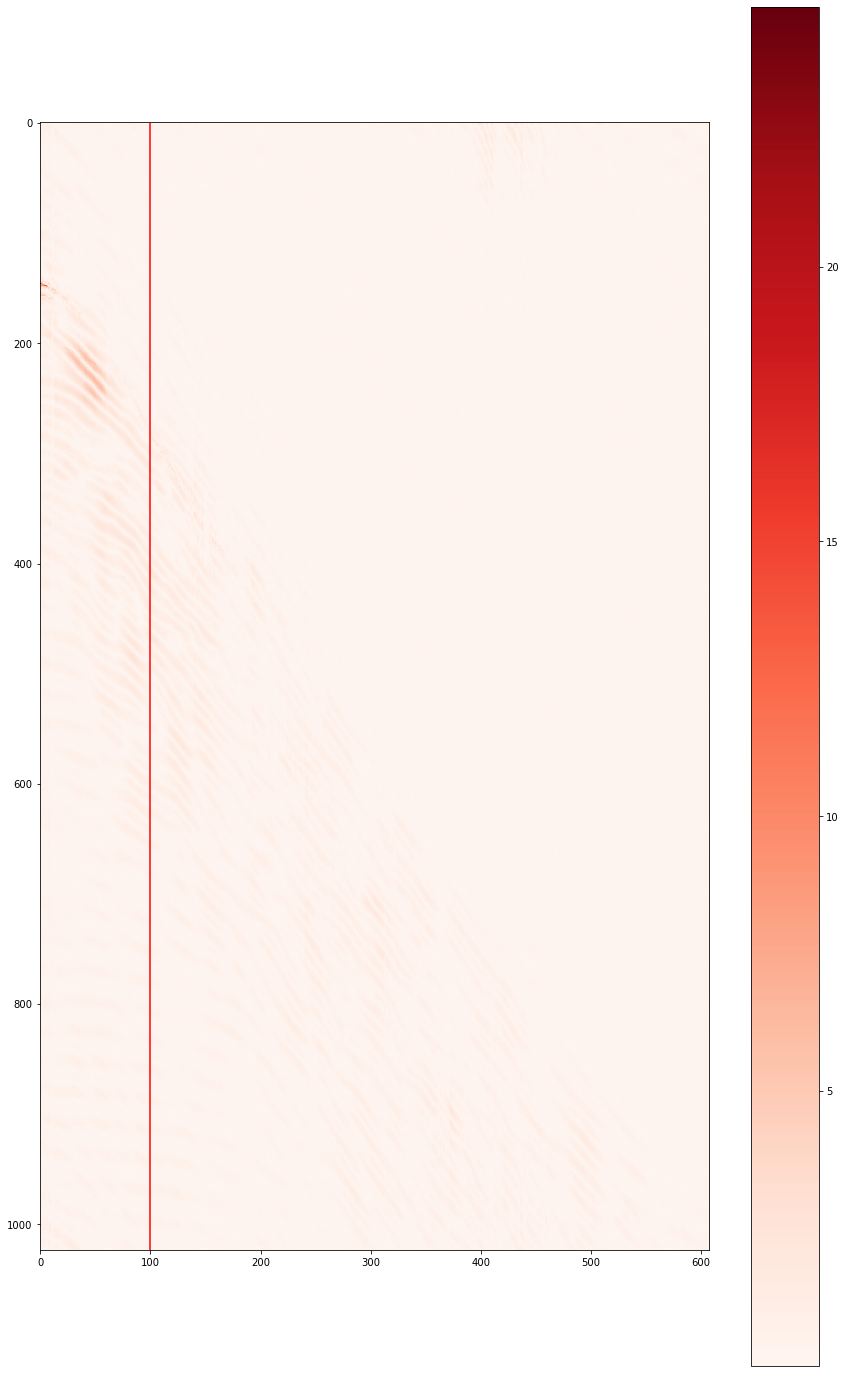

RMSE test Frequency = 0.0001252853874908817
RMSE pred Frequency = 0.00014235165689362828


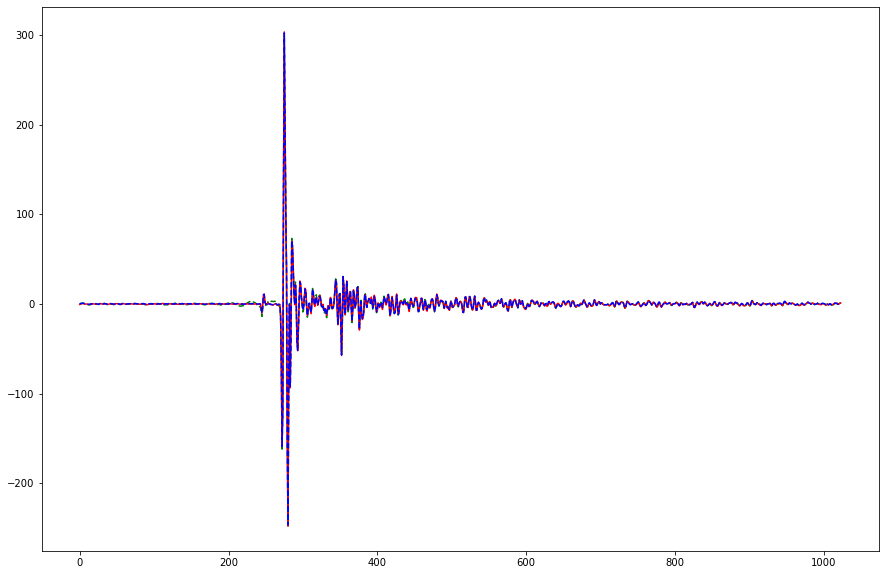

The overall error of the approximation is: 1750342565.5498452
The overall error of the input data is: 10762562956.027569
Or in other words, the error diminished by 83.73674957627479 percent


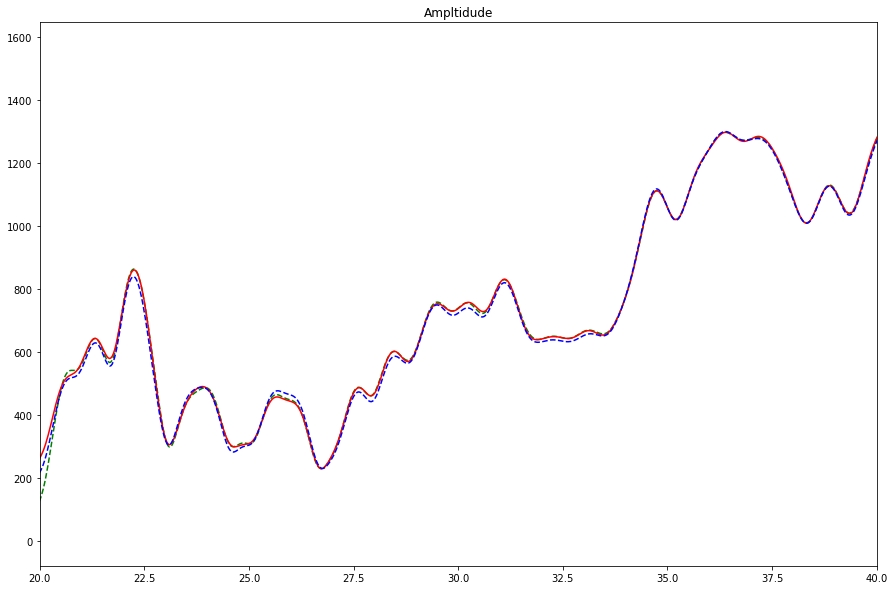

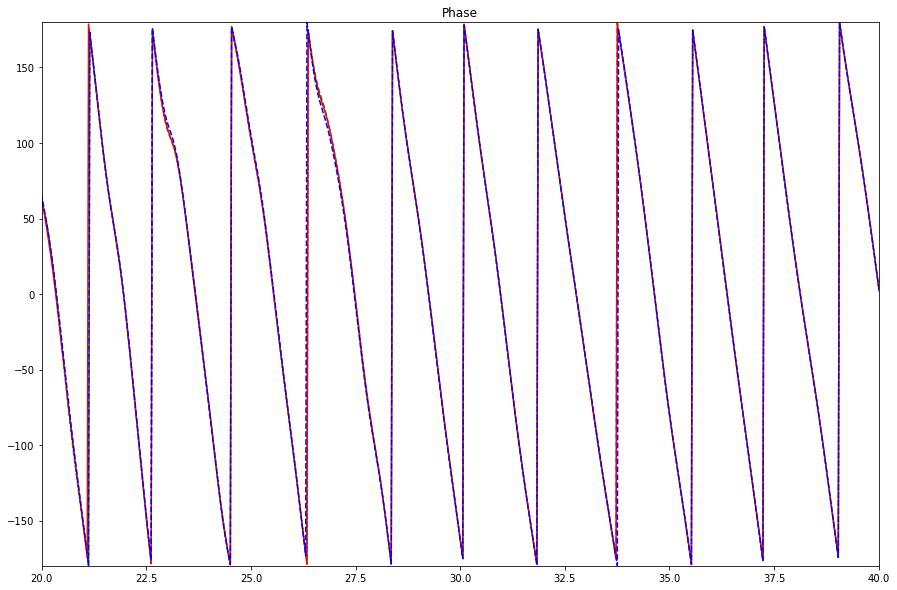

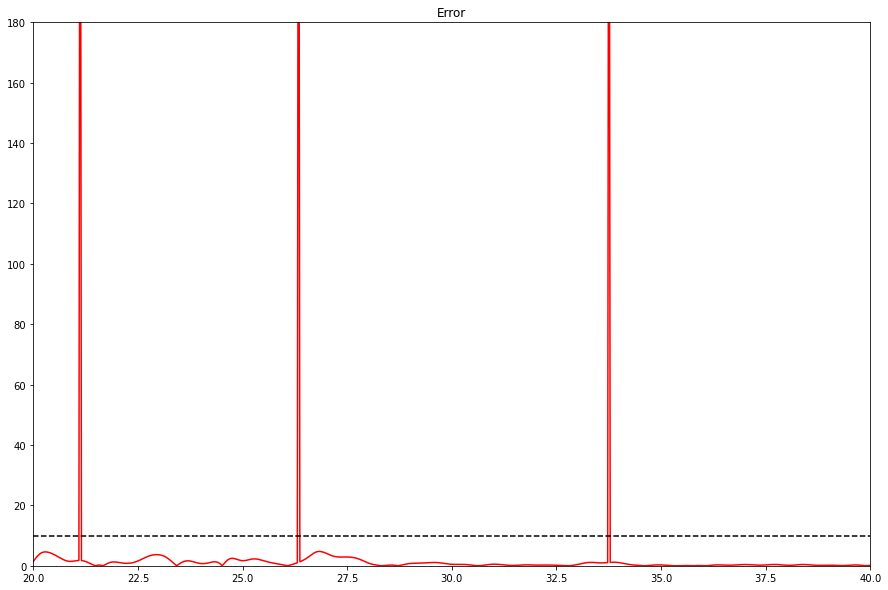

saved


In [8]:
#### In the above reconstruction we have artifacts from windowing SO USE THIS ONE!

trace = 100
nfft = 32*len(Y_test[0,:,0,:])

gather_obj = np.zeros((end_time,TracesPerGather+1,1))
gather_pred = np.zeros((end_time,TracesPerGather+1,1))
gather_test = np.zeros((end_time,TracesPerGather+1,1))

level = -output_height
location = 0
for ind in range(int(len(Y_test[:,0,0,0])/Ntestsamples)):
    
    if ind < 20:
        bound_top = 0
        bound_bottom = output_height
        
    elif ind >= 60:
        bound_top = output_height
        bound_bottom = input_height
    
    else:
        bound_top = int(output_height/2)
        bound_bottom = int((output_height+input_height)/2)
    
    
    if (ind%20) == 0:
        bound_left = 0
        bound_right = output_width
        level += output_height
        location = 0
        
    elif ((ind+1)%20) == 0:
        bound_left = output_width
        bound_right = input_width
        continue
    else:
        bound_left = int(output_width/2)
        bound_right = int((output_width+input_width)/2)
        location += output_width

        
    gather_obj[int(level):int(level+output_height),int(location):int(location+output_width)] = ((Y_test[ind,int(bound_top):
                                                                                                          int(bound_bottom),
                                                                                                          int(bound_left):
                                                                                                          int(bound_right),:]*2)-1)*normfac
    gather_pred[int(level):int(level+output_height),int(location):int(location+output_width)] = ((preds_test[ind,int(bound_top):
                                                                                                          int(bound_bottom),
                                                                                                          int(bound_left):
                                                                                                          int(bound_right),:]*2)-1)*normfac
    gather_test[int(level):int(level+output_height),int(location):int(location+output_width)] = ((X_test[ind,int(bound_top):
                                                                                                          int(bound_bottom),
                                                                                                          int(bound_left):
                                                                                                          int(bound_right),:]*2)-1)*normfac
#Unfortunately, as the script is imperfect, part of the full gather is missing and thus the result contains zeros on the right side.
#So, we will remove those:
gather_obj = gather_obj[:,0:int(location+output_width)]
gather_pred = gather_pred[:,0:int(location+output_width)]
gather_test = gather_test[:,0:int(location+output_width)]


#Next we will use various measures to compare the accuracy of the reconstruction.

time_error = np.sum((gather_obj-gather_pred)**2)
time_error2 = np.sum((gather_obj-gather_test)**2)

#PSNR:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = np.max(original)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def SSIM(original, compressed):
    original_tf = tf.convert_to_tensor(original)
    compressed_tf = tf.convert_to_tensor(compressed)
    ssim = tf.reduce_mean(tf.image.ssim(original_tf, compressed_tf, 1.0))
    return ssim
    
print(f'The overall error of the approximation is: {time_error}')
print(f'The overall error of the input data is: {time_error2}')
print(f'Or in other words, the error diminished by {(1-(time_error/time_error2))*100} percent')
print(f'RMSE test = {np.sqrt(np.mean((gather_obj-gather_test)**2))/(np.max(gather_obj)-np.min(gather_obj))}')
print(f'RMSE pred = {np.sqrt(np.mean((gather_obj-gather_pred)**2))/(np.max(gather_obj)-np.min(gather_obj))}')
print(f'PSNR test = {PSNR(gather_obj,gather_test)}')
print(f'PSNR pred = {PSNR(gather_obj,gather_pred)}')
print(f'SSIM test = {SSIM(gather_obj,gather_test)}')
print(f'SSIM pred = {SSIM(gather_obj,gather_pred)}')

f = plt.figure(figsize=(15,25))    
plt.imshow(abs(gather_obj-gather_pred),cmap = 'Reds')
plt.vlines(trace,0,end_time-1,'r')
plt.colorbar()
plt.show()

x=np.linspace(0,1/dt,nfft).reshape(nfft,1)
gather_obj_f = fft(gather_obj,n = nfft,axis=0)
gather_pred_f = fft(gather_pred,n = nfft,axis=0)
gather_test_f = fft(gather_test,n = nfft,axis=0)

print(f'RMSE test Frequency = {abs(np.sqrt(np.mean((gather_obj_f-gather_test_f)**2))/(np.max(gather_obj_f)-np.min(gather_obj_f)))}')
print(f'RMSE pred Frequency = {abs(np.sqrt(np.mean((gather_obj_f-gather_pred_f)**2))/(np.max(gather_obj_f)-np.min(gather_obj_f)))}')

gather_obj_phi = np.angle(fft(gather_obj,n = nfft,axis=0))*180/np.pi
gather_pred_phi = np.angle(fft(gather_pred,n = nfft,axis=0))*180/np.pi
gather_test_phi = np.angle(fft(gather_test,n = nfft,axis=0))*180/np.pi

f = plt.figure(figsize=(15,10))
plt.plot(gather_test[:,trace,:],'--g')
plt.plot(gather_obj[:,trace,:],'r')
plt.plot(gather_pred[:,trace,:],'--b')
# plt.ylim()
# plt.xlim(0,125)
plt.show()

freq_error = np.sum(np.abs(gather_obj_f-gather_pred_f)**2)
freq_error2 = np.sum(np.abs(gather_obj_f-gather_test_f)**2)
print(f'The overall error of the approximation is: {freq_error}')
print(f'The overall error of the input data is: {freq_error2}')
print(f'Or in other words, the error diminished by {(1-(freq_error/freq_error2))*100} percent')

f = plt.figure(figsize=(15,10))
plt.plot(x,abs(gather_test_f[:,trace,:]),'--g')
plt.plot(x,abs(gather_obj_f[:,trace,:]),'r')
plt.plot(x,abs(gather_pred_f[:,trace,:]),'--b')
# plt.ylim(0,2000)
plt.xlim(20,40)
plt.title('Ampltidude')
plt.show()

f = plt.figure(figsize=(15,10))
plt.plot(x,(gather_test_phi[:,trace,:]),'--g')
plt.plot(x,(gather_obj_phi[:,trace,:]),'r')
plt.plot(x,(gather_pred_phi[:,trace,:]),'--b')
plt.ylim(-180,180)
plt.xlim(20,40)
plt.title('Phase')
plt.show()

f = plt.figure(figsize=(15,10))
plt.plot(x,np.abs(gather_obj_phi[:,trace,:]-gather_pred_phi[:,trace,:]),'r')
plt.axhline(y=10, color='k', linestyle='--')
plt.ylim(0,180)
plt.xlim(20,40)
plt.title('Error')
plt.show()

##Saving the gathers
# file_path = 'gathers_'+ str(flp) + '_'+ str(flp+5) + '_2.mat'
# scipy.io.savemat(file_path, {'target': gather_obj,'pred':gather_pred,'test':gather_test})
# print('saved')